In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

Kaggleの Home Credit Default Risk コンペティションの学習および推定を行います。

[Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk)

### 【問題1】コンペティション内容の確認

コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

1. 何を学習し、何を予測するのか
2. どのようなファイルを作りKaggleに提出するか
3. 提出されたものはどういった指標値で評価されるのか

#### 1. 何を学習し、何を予測するのか

application_train.csvを学習し、顧客の返済能力を予測する。

#### 2. どのようなファイルを作りKaggleに提出するか

ファイルにはヘッダが含まれており、次のような形式になっていなければなりません。

In [2]:
example = pd.DataFrame({'SK_ID_CURR' : [100001, 100005, 100013], 
                                               'TARGET' : [0.1, 0.9, 0.2]})

example

,SK_ID_CURR,TARGET
0,100001,0.1
1,100005,0.9
2,100013,0.2


#### 3. 提出されたものはどういった指標値で評価されるのか

提出物は、予測された確率と観測された目標との間のROC曲線の下の面積(AUC)で評価されます。

テストセットの各SK_ID_CURRについて、TARGET変数の確率を予測する必要があります。

## ベースラインモデルの作成

まずは単純な方法による ベースラインモデル　を作成します。精度の基準となるモデルです。

精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

### 【問題2】学習と検証

データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。


検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [3]:
#訓練データの読み込み
train = pd.read_csv("application_train.csv")
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


まずはTARGETと相関性の高いものを探し出す。
その上で、正の相関性の高い特徴量と、負の相関性が高い特徴量の中から各1個ずつ特徴量を選び、計2個の特徴量を標準化し、ランダムフォレストで学習推定を行い、これをベースラインモデルとする。ベースラインでの欠損値対応は、0に変換する、という対応をとる。

In [4]:
#目的変数(TARGET)と正の相関性の高いものを、相関性が高い方から順に10個表示

train_corr = train.corr()
train_corr_plus = train_corr['TARGET'].sort_values(ascending=False)# ascending=Trueで負の相関性になる
print('Most Positive Correlations:\n', train_corr_plus[1:].head(10))

Most Positive Correlations:
 DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
Name: TARGET, dtype: float64


In [5]:
#目的変数(TARGET)と正の相関性の高いものを、相関性が高い方から順に10個表示

train_corr_minus = train_corr['TARGET'].sort_values(ascending=True)
print('Most Negative Correlations:\n', train_corr_minus.head(10))

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


正の相関性が最も高いのは**DAYS_BIRTH**、負の相関性の最も高いものは**EXT_SOURCE_3**であるので、これら2つを用いてランダムフォレストにてベースラインを作成する。

In [6]:
#各特徴量を抜き出す
x1 = pd.DataFrame(train, columns = ['DAYS_BIRTH'])
x2 = pd.DataFrame(train, columns = ['EXT_SOURCE_3'])
y = pd.DataFrame(train, columns = ['TARGET'])
display(x1)
display(x2)
display(y)

,DAYS_BIRTH
0,-9461
1,-16765
2,-19046
3,-19005
4,-19932
...,...
307506,-9327
307507,-20775
307508,-14966
307509,-11961


,EXT_SOURCE_3
0,0.139376
1,NaN
2,0.729567
3,NaN
4,NaN
...,...
307506,NaN
307507,NaN
307508,0.218859
307509,0.661024


,TARGET
0,1
1,0
2,0
3,0
4,0
...,...
307506,0
307507,0
307508,0
307509,1


In [7]:
#欠損値を調べる
print( x1.isnull().sum())
print(x2.isnull().sum())
print(y.isnull().sum())

DAYS_BIRTH    0
dtype: int64
EXT_SOURCE_3    60965
dtype: int64
TARGET    0
dtype: int64


In [8]:
#欠損値を0で埋める
x2.fillna(0, inplace=True)

#欠損値が消えたか再確認
x2.isnull().sum()

EXT_SOURCE_3    0
dtype: int64

In [9]:
# データセットを作る
X = pd.concat([x1, x2], axis=1)
display(X)

,DAYS_BIRTH,EXT_SOURCE_3
0,-9461,0.139376
1,-16765,0.000000
2,-19046,0.729567
3,-19005,0.000000
4,-19932,0.000000
...,...,...
307506,-9327,0.000000
307507,-20775,0.000000
307508,-14966,0.218859
307509,-11961,0.661024


In [10]:
# numpy配列に変換
X = X.values
y = y.values

print(type(X))
print(type(y))
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(307511, 1)


In [11]:
#データを分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)


print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_train: (230633, 2)
y_train: (230633, 1)
X_val: (76878, 2)
y_val: (76878, 1)


In [12]:
#標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

print('X_train_mean:', X_train_std.mean(axis=0))
print('X_train_std:', X_train_std.std(axis=0))
print('X_val_mean:', X_val_std.mean(axis=0))
print('X_val_std:', X_val_std.std(axis=0))

X_train_mean: [-3.14524600e-17 -5.87985808e-14]
X_train_std: [1. 1.]
X_val_mean: [ 0.00680216 -0.00115887]
X_val_std: [0.99738035 1.00151887]


In [13]:
#ランダムフォレストで学習、推定
from sklearn.ensemble import RandomForestClassifier# 2値分類問題なのでClassifier
rf = RandomForestClassifier()
rf.fit(X_train_std, y_train)
y_pred_rf_base = rf.predict_proba(X_val_std)# probaで各確率を返す
y_pred_rf_base# ［0である確率, 1である確率］

/Users/SHOTA/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.89, 0.11],
       ...,
       [1.  , 0.  ],
       [0.96, 0.04],
       [1.  , 0.  ]])

AUC 0.5733748564410991


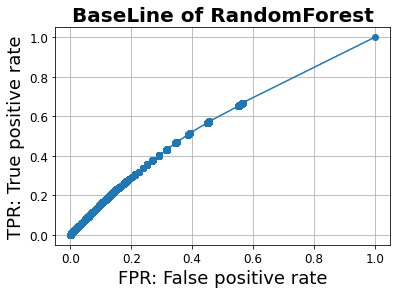

In [14]:
# 評価（ROC曲線とAUC）
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# 3つの要素は順番にfpr, tpr, thresholdsで、それぞれFPR（偽陽性率）、TPR（真陽性率）、閾値
fpr, tpr, threshold = roc_curve(y_val, y_pred_rf_base[:, 1])# 1である確率なので、欲しいのは一列目
plt.plot(fpr, tpr, marker='o')
plt.tick_params(labelsize=12)
plt.title('BaseLine of RandomForest', size=20, weight='heavy')
plt.xlabel('FPR: False positive rate', size=18)
plt.ylabel('TPR: True positive rate', size=18)
plt.grid()
print('AUC', roc_auc_score(y_val, y_pred_rf_base[:, 1]))

In [15]:
df_pred = pd.DataFrame({'BASELINE:feature_2':roc_auc_score(y_val, y_pred_rf_base[:, 1])}, 
                      index = ['AUC'])
df_pred

,BASELINE:feature_2
AUC,0.573375


参考URL①：

[scikit-learnでROC曲線とそのAUCを算出](https://note.nkmk.me/python-sklearn-roc-curve-auc-score/)

### 【問題3】テストデータに対する推定

テストデータ（`application_test.csv`）に対して推定を行い、Kaggleに提出を行ってください。


正しく提出が行えていれば、精度は低くても構いません。

In [16]:
# テストデータの読み込み
test = pd.read_csv("application_test.csv")
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# データセットの作成
X_test = pd.DataFrame(test, columns=['DAYS_BIRTH', 'EXT_SOURCE_3'])
print('type:', type(X_test))
print('shape:', X_test.shape)
X_test

type: <class 'pandas.core.frame.DataFrame'>
shape: (48744, 2)


,DAYS_BIRTH,EXT_SOURCE_3
0,-19241,0.159520
1,-18064,0.432962
2,-20038,0.610991
3,-13976,0.612704
4,-13040,NaN
...,...,...
48739,-19970,0.643026
48740,-11186,NaN
48741,-15922,0.283712
48742,-13968,0.595456


In [18]:
#欠損値を0で代替
X_test.fillna(0, inplace=True)

#欠損値が消えたか再確認
X_test.isnull().sum()

DAYS_BIRTH      0
EXT_SOURCE_3    0
dtype: int64

In [19]:
# numpy  arrayに変換
X_test = X_test.values
type(X_test)

numpy.ndarray

In [20]:
# 検証データで推定
y_pred_rf = rf.predict_proba(X_test)# probaで各確率を返す
print(y_pred_rf.shape)
y_pred_rf# ［0である確率, 1である確率］

(48744, 2)


array([[0.88, 0.12],
       [0.93, 0.07],
       [1.  , 0.  ],
       ...,
       [0.67, 0.33],
       [0.98, 0.02],
       [0.72, 0.28]])

In [21]:
# Submission dataframe
submit = pd.DataFrame(test['SK_ID_CURR'])
submit['TARGET'] = y_pred_rf[:, 1]# TARGETである確率

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.12
1,100005,0.07
2,100013,0.00
3,100028,0.00
4,100038,0.03


### 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

1. どの特徴量を使うか
2. どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。


精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

#### 1. どの特徴量を使うか
問題2では2つの特徴量を用いたが、今回は正の相関のあるもの、負の相関のあるものから各3個を用いて、計6個の特徴量を用いて学習を行う。
各特徴量は上位3つを、それぞれ選択する。

さらにここでは異常値の処理も行ってみる。
異常値の処理とは、ここでは、DAYS_BIRTHが負の値となっている為、-1をかけて、365で除し、年単位にすることである。

In [22]:
#データセットの作成

x1 = pd.DataFrame(train, columns = ['DAYS_BIRTH'])
x1_after = x1 / -365# 異常値の処理
x5 = pd.DataFrame(train, columns = ['REGION_RATING_CLIENT_W_CITY', 
                                'REGION_RATING_CLIENT', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 
                                'EXT_SOURCE_1'])#欠損値未対応で再作成

X_6 = pd.concat([x1_after, x5], axis=1)

X_6

,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1
0,25.920548,2,2,0.139376,0.262949,0.083037
1,45.931507,1,1,NaN,0.622246,0.311267
2,52.180822,2,2,0.729567,0.555912,NaN
3,52.068493,2,2,NaN,0.650442,NaN
4,54.608219,2,2,NaN,0.322738,NaN
...,...,...,...,...,...,...
307506,25.553425,1,1,NaN,0.681632,0.145570
307507,56.917808,2,2,NaN,0.115992,NaN
307508,41.002740,3,3,0.218859,0.535722,0.744026
307509,32.769863,2,2,0.661024,0.514163,NaN


In [23]:
#欠損値を確認
X_6.isnull().sum()

DAYS_BIRTH                          0
REGION_RATING_CLIENT_W_CITY         0
REGION_RATING_CLIENT                0
EXT_SOURCE_3                    60965
EXT_SOURCE_2                      660
EXT_SOURCE_1                   173378
dtype: int64

In [24]:
# 欠損値を0で代替
X_6.fillna(0, inplace=True)
X_6.isnull(). sum()

DAYS_BIRTH                     0
REGION_RATING_CLIENT_W_CITY    0
REGION_RATING_CLIENT           0
EXT_SOURCE_3                   0
EXT_SOURCE_2                   0
EXT_SOURCE_1                   0
dtype: int64

In [25]:
#numpy arrayに変換
X_6 = X_6.values
type(X_6)

numpy.ndarray

In [26]:
# データ分割
X_train, X_val, y_train, y_val = train_test_split(X_6, y, test_size=0.25, random_state=0)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_train: (230633, 6)
y_train: (230633, 1)
X_val: (76878, 6)
y_val: (76878, 1)


In [27]:
#標準化

scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

print('X_train_mean:', X_train_std.mean(axis=0))
print('X_train_std:', X_train_std.std(axis=0))
print('X_val_mean:', X_val_std.mean(axis=0))
print('X_val_std:', X_val_std.std(axis=0))

X_train_mean: [-1.43493184e-14  1.23366321e-15  3.32880938e-15 -5.87985808e-14
  2.40663356e-15 -1.08529270e-14]
X_train_std: [1. 1. 1. 1. 1. 1.]
X_val_mean: [-0.00680216  0.00388828  0.00309021 -0.00115887  0.00064598  0.0019243 ]
X_val_std: [0.99738035 0.99883237 0.99827955 1.00151887 1.00141636 0.99911649]


In [28]:
#学習

rf = RandomForestClassifier()
rf.fit(X_train_std, y_train)
y_pred_rf_6 = rf.predict_proba(X_val_std)
y_pred_rf_6

/Users/SHOTA/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([[0.73, 0.27],
       [0.99, 0.01],
       [0.92, 0.08],
       ...,
       [0.98, 0.02],
       [0.75, 0.25],
       [0.91, 0.09]])

In [29]:
#評価　

print('AUC', roc_auc_score(y_val, y_pred_rf_6[:, 1]))

AUC 0.6738909802308296


In [30]:
#AUCを表に追加

df_pred = df_pred.assign(ZERO_FEATURE_6 = [roc_auc_score(y_val, y_pred_rf_6[:, 1])])
df_pred

,BASELINE:feature_2,ZERO_FEATURE_6
AUC,0.573375,0.673891


#### 【結果】
特徴量を増やしたら、AUCは上がった！

#### 2. どう前処理をするか

以下の二点を改良してみる。

1. 欠損値のある行を削除する
2. 欠損値を中央値で代替する


特徴量を6個に増やしたモデルに、以上の2点を変更して、改良を行う。

#### 2.1. 欠損値のある行を削除する

In [31]:
x1 = pd.DataFrame(train, columns = ['DAYS_BIRTH'])
x1_after = x1 / -365# 異常値の処理
x5 = pd.DataFrame(train, columns = ['REGION_RATING_CLIENT_W_CITY', 
                                'REGION_RATING_CLIENT', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 
                                'EXT_SOURCE_1'])#欠損値未対応で再作成

X_1 = pd.concat([x1_after, x5], axis=1)
y_1 = pd.DataFrame(train, columns = ['TARGET'])
Xy = pd.concat([X_1, y_1], axis=1)
Xy

,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,TARGET
0,25.920548,2,2,0.139376,0.262949,0.083037,1
1,45.931507,1,1,NaN,0.622246,0.311267,0
2,52.180822,2,2,0.729567,0.555912,NaN,0
3,52.068493,2,2,NaN,0.650442,NaN,0
4,54.608219,2,2,NaN,0.322738,NaN,0
...,...,...,...,...,...,...,...
307506,25.553425,1,1,NaN,0.681632,0.145570,0
307507,56.917808,2,2,NaN,0.115992,NaN,0
307508,41.002740,3,3,0.218859,0.535722,0.744026,0
307509,32.769863,2,2,0.661024,0.514163,NaN,1


In [32]:
#欠損値のある行を削除
Xy = Xy.dropna()
Xy

,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,TARGET
0,25.920548,2,2,0.139376,0.262949,0.083037,1
6,37.747945,2,2,0.492060,0.724000,0.774761,0
8,55.065753,2,2,0.751724,0.205747,0.587334,0
10,27.936986,2,2,0.363945,0.651862,0.319760,0
11,55.936986,2,2,0.652897,0.555183,0.722044,0
...,...,...,...,...,...,...,...
307499,46.542466,2,2,0.206779,0.649123,0.665343,0
307500,55.863014,2,2,0.337673,0.789389,0.896042,0
307503,32.520548,2,2,0.609276,0.501221,0.243466,0
307508,41.002740,3,3,0.218859,0.535722,0.744026,0


In [33]:
#numpy ndarrayに変換
Xy = Xy.values

# Xとyに再分割後
X1 = Xy[:, :6]
y1 = Xy[:, 6:]
print(X1)
print(y1)

[[25.92054795  2.          2.          0.13937578  0.26294859  0.08303697]
 [37.74794521  2.          2.          0.49206009  0.72399985  0.77476141]
 [55.06575342  2.          2.          0.75172371  0.20574729  0.58733405]
 ...
 [32.52054795  2.          2.          0.60927567  0.501221    0.24346585]
 [41.00273973  3.          3.          0.21885908  0.53572175  0.7440264 ]
 [46.18082192  1.          1.          0.1139224   0.7085689   0.73445967]]
[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [34]:
# データ分割

X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.25, random_state=0)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_train: (82191, 6)
y_train: (82191, 1)
X_val: (27398, 6)
y_val: (27398, 1)


In [35]:
#標準化

scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

print('X_train_mean:', X_train_std.mean(axis=0))
print('X_train_std:', X_train_std.std(axis=0))
print('X_val_mean:', X_val_std.mean(axis=0))
print('X_val_std:', X_val_std.std(axis=0))

X_train_mean: [-3.71240203e-15  1.99326104e-15 -2.94754346e-15  9.27391252e-14
  2.31493246e-14  1.40747463e-14]
X_train_std: [1. 1. 1. 1. 1. 1.]
X_val_mean: [ 0.00907648  0.00463357  0.0070647  -0.00194659  0.00044325  0.01410794]
X_val_std: [0.9986827  0.99337135 0.99622427 1.0002857  0.99594527 0.99972294]


In [36]:
#学習

rf = RandomForestClassifier()
rf.fit(X_train_std, y_train)
y_pred_rf_non = rf.predict_proba(X_val_std)
y_pred_rf_non

/Users/SHOTA/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([[0.81, 0.19],
       [0.92, 0.08],
       [0.66, 0.34],
       ...,
       [1.  , 0.  ],
       [0.94, 0.06],
       [0.86, 0.14]])

In [37]:
#評価　

print('AUC', roc_auc_score(y_val, y_pred_rf_non[:, 1]))

AUC 0.6924232430097816


In [38]:
#AUCを表に追加

df_pred = df_pred.assign(Non_missing_feature_6 = [roc_auc_score(y_val, y_pred_rf_non[:, 1])])
df_pred

,BASELINE:feature_2,ZERO_FEATURE_6,Non_missing_feature_6
AUC,0.573375,0.673891,0.692423


#### 【結果】
欠損値を削除することでデータ量が少なくなったが、結果的にAUCは上がった。

次はデータ量の減らない、中央値での代替を行ってみる。

#### 2.2. 欠損値を中央値で代替する

In [39]:
# データセットの作成

x1 = pd.DataFrame(train, columns = ['DAYS_BIRTH'])
x1_after = x1 / -365# 異常値の処理
x5 = pd.DataFrame(train, columns = ['REGION_RATING_CLIENT_W_CITY', 
                                'REGION_RATING_CLIENT', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 
                                'EXT_SOURCE_1'])#欠損値未対応で再作成

X_1 = pd.concat([x1_after, x5], axis=1)
X_1

,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1
0,25.920548,2,2,0.139376,0.262949,0.083037
1,45.931507,1,1,NaN,0.622246,0.311267
2,52.180822,2,2,0.729567,0.555912,NaN
3,52.068493,2,2,NaN,0.650442,NaN
4,54.608219,2,2,NaN,0.322738,NaN
...,...,...,...,...,...,...
307506,25.553425,1,1,NaN,0.681632,0.145570
307507,56.917808,2,2,NaN,0.115992,NaN
307508,41.002740,3,3,0.218859,0.535722,0.744026
307509,32.769863,2,2,0.661024,0.514163,NaN


In [40]:
#欠損値を列の中央値で代替する

X_1_center =  X_1.fillna(X_1.median())
X_1_center

,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1
0,25.920548,2,2,0.139376,0.262949,0.083037
1,45.931507,1,1,0.535276,0.622246,0.311267
2,52.180822,2,2,0.729567,0.555912,0.505998
3,52.068493,2,2,0.535276,0.650442,0.505998
4,54.608219,2,2,0.535276,0.322738,0.505998
...,...,...,...,...,...,...
307506,25.553425,1,1,0.535276,0.681632,0.145570
307507,56.917808,2,2,0.535276,0.115992,0.505998
307508,41.002740,3,3,0.218859,0.535722,0.744026
307509,32.769863,2,2,0.661024,0.514163,0.505998


In [41]:
# 欠損値の再確認
X_1_center.isnull().sum()

DAYS_BIRTH                     0
REGION_RATING_CLIENT_W_CITY    0
REGION_RATING_CLIENT           0
EXT_SOURCE_3                   0
EXT_SOURCE_2                   0
EXT_SOURCE_1                   0
dtype: int64

In [42]:
# numpy ndarrayに変換
X_a = X_1_center.values
type(X_a)

numpy.ndarray

In [43]:
# データ分割

X_train, X_val, y_train, y_val = train_test_split(X_a, y, test_size=0.25, random_state=0)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_train: (230633, 6)
y_train: (230633, 1)
X_val: (76878, 6)
y_val: (76878, 1)


In [44]:
#標準化

scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

print('X_train_mean:', X_train_std.mean(axis=0))
print('X_train_std:', X_train_std.std(axis=0))
print('X_val_mean:', X_val_std.mean(axis=0))
print('X_val_std:', X_val_std.std(axis=0))

X_train_mean: [-1.43493184e-14  1.23366321e-15  3.32880938e-15 -1.92051973e-12
 -1.45090437e-14 -5.43234123e-12]
X_train_std: [1. 1. 1. 1. 1. 1.]
X_val_mean: [-0.00680216  0.00388828  0.00309021  0.00240263 -0.00058399 -0.00277334]
X_val_std: [0.99738035 0.99883237 0.99827955 0.99872093 1.0029312  1.00033861]


In [45]:
#学習

rf = RandomForestClassifier()
rf.fit(X_train_std, y_train)
y_pred_rf_center = rf.predict_proba(X_val_std)
y_pred_rf_center

/Users/SHOTA/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([[0.6 , 0.4 ],
       [1.  , 0.  ],
       [0.82, 0.18],
       ...,
       [0.99, 0.01],
       [0.84, 0.16],
       [0.98, 0.02]])

In [46]:
#評価　

print('AUC', roc_auc_score(y_val, y_pred_rf_center[:, 1]))

AUC 0.671729750796668


In [47]:
#AUCを表に追加

df_pred = df_pred.assign(center_missing_feature_6 = [roc_auc_score(y_val, y_pred_rf_center[:, 1])])
df_pred

,BASELINE:feature_2,ZERO_FEATURE_6,Non_missing_feature_6,center_missing_feature_6
AUC,0.573375,0.673891,0.692423,0.67173


欠損値を削除して、特徴量を6つにしたモデルが最も AUCが良かったので、このモデルをkaggleに提出する。

In [48]:
# データセットの作成

x1 = pd.DataFrame(test, columns = ['DAYS_BIRTH'])
x1_after = x1 / -365# 異常値の処理

#SK_ID_CURRも一緒に入れておくと、後でデータ削除の際に、該当するSK_ID_CURRも消える
x_test_submit = pd.DataFrame(test, columns=['REGION_RATING_CLIENT_W_CITY', 
                                'REGION_RATING_CLIENT', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 
                                'EXT_SOURCE_1', 'SK_ID_CURR'])

X_test_submit = pd.concat([x1_after, x_test_submit], axis=1)

print('X_type:', type(X_test_submit))
print('X_shape:', X_test_submit.shape)

X_test_submit

X_type: <class 'pandas.core.frame.DataFrame'>
X_shape: (48744, 7)


,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,SK_ID_CURR
0,52.715068,2,2,0.159520,0.789654,0.752614,100001
1,49.490411,2,2,0.432962,0.291656,0.564990,100005
2,54.898630,2,2,0.610991,0.699787,NaN,100013
3,38.290411,2,2,0.612704,0.509677,0.525734,100028
4,35.726027,2,2,NaN,0.425687,0.202145,100038
...,...,...,...,...,...,...,...
48739,54.712329,3,3,0.643026,0.648575,NaN,456221
48740,30.646575,2,2,NaN,0.684596,NaN,456222
48741,43.621918,2,2,0.283712,0.632770,0.733503,456223
48742,38.268493,2,2,0.595456,0.445701,0.373090,456224


In [49]:
#欠損値のある行を削除
X_test_submit_non = X_test_submit.dropna()
type(X_test_submit_non)

pandas.core.frame.DataFrame

In [50]:
#欠損値削除後の確認
X_test_submit_non.isnull().sum()

DAYS_BIRTH                     0
REGION_RATING_CLIENT_W_CITY    0
REGION_RATING_CLIENT           0
EXT_SOURCE_3                   0
EXT_SOURCE_2                   0
EXT_SOURCE_1                   0
SK_ID_CURR                     0
dtype: int64

In [51]:
# 検証データで推定する時にSK_ID_CURRが邪魔になるので、切り落とす
X_test_submit_non_1 =X_test_submit_non.drop(columns='SK_ID_CURR')
X_test_submit_non_1

,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1
0,52.715068,2,2,0.159520,0.789654,0.752614
1,49.490411,2,2,0.432962,0.291656,0.564990
3,38.290411,2,2,0.612704,0.509677,0.525734
6,45.712329,2,2,0.651260,0.571084,0.760851
7,26.071233,2,2,0.312365,0.613033,0.565290
...,...,...,...,...,...,...
48736,59.671233,2,2,0.631355,0.471719,0.851722
48737,53.142466,2,2,0.255332,0.689832,0.442558
48738,32.076712,2,2,0.240541,0.762352,0.174671
48741,43.621918,2,2,0.283712,0.632770,0.733503


In [52]:
# 検証データで推定
y_pred_rf_submit = rf.predict_proba(X_test_submit_non_1)# probaで各確率を返す
print(y_pred_rf_submit.shape)
y_pred_rf_submit# ［0である確率, 1である確率］

(23584, 2)


array([[0.91, 0.09],
       [0.84, 0.16],
       [0.88, 0.12],
       ...,
       [0.96, 0.04],
       [0.93, 0.07],
       [0.88, 0.12]])

In [53]:
# Submission dataframe
submit_true = pd.DataFrame(X_test_submit_non['SK_ID_CURR'])

submit_true['TARGET'] = y_pred_rf_submit[:, 1]# TARGET1である確率

submit_true.head()

,SK_ID_CURR,TARGET
0,100001,0.09
1,100005,0.16
3,100028,0.12
6,100057,0.11
7,100065,0.07


In [54]:
# Save the submission dataframe
submit_true.to_csv('submission.csv', index = False)